In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [17]:
class Node:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        ig = parent_entropy - child_entropy
        return ig

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        entropy = -np.sum(probs * np.log2(probs))
        return entropy

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        _, counts = np.unique(y, return_counts=True)
        return max(zip(_, counts), key=lambda x: x[1])[0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

In [41]:
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['wine_region'] = wine.target

In [42]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_region
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [45]:
df.isna().sum().sum()

0

In [44]:
df['wine_region'].value_counts()

wine_region
1    71
0    59
2    48
Name: count, dtype: int64

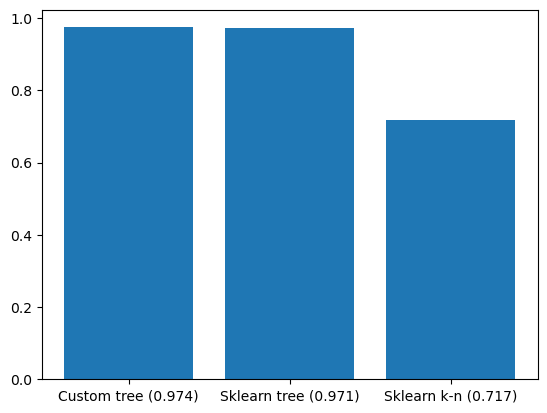

In [77]:
X = df.drop(columns=['wine_region']).values
y = df['wine_region'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=228, stratify=y
)

my_clf = DecisionTree(max_depth=5)
my_clf.fit(X_train, y_train)
f1_my = f1_score(y_test, my_clf.predict(X_test), average='macro')

sk = DecisionTreeClassifier(max_depth=5)
sk.fit(X_train, y_train)
f1_sk = f1_score(y_test, sk.predict(X_test), average='macro')

sk_nb = KNeighborsClassifier(n_neighbors=15)
sk_nb.fit(X_train, y_train)
f1_sk_nb = f1_score(y_test, sk_nb.predict(X_test), average='macro')

plt.bar([f'Custom tree ({f1_my:.3f})', f'Sklearn tree ({f1_sk:.3f})', f'Sklearn k-n ({f1_sk_nb:.3f})'], [f1_my, f1_sk,f1_sk_nb])
plt.show()